1. Veri Setinin İlk 5 Satırı (Ham Hali):


,Zurich_Class,Spot_Size,Spot_Distribution,Activity,Evolution,Prev_24_Hour,Hist_Complex,Did_Become_Complex,Area,Area_Largest,target
0,D,R,O,1,3,1,1,2,1,1,0
1,C,S,O,1,3,1,1,2,1,1,0
2,H,R,X,1,2,1,1,1,1,1,0
3,H,S,X,1,1,1,1,2,1,1,0
4,C,A,O,1,2,1,1,2,1,1,0


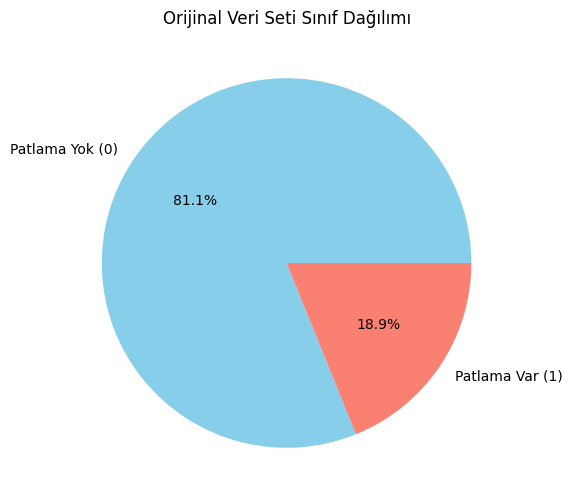

Toplam Veri Sayısı: 1065
Patlama Olmayan (0): 864
Patlama Olan (1): 201


In [1]:
# --- HÜCRE 1: Kütüphaneler ve Veri Yükleme ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.combine import SMOTETomek # Gelişmiş dengeleme aracı
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Veriyi Çekme
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/solar-flare/flare.data2"
columns = ["Zurich_Class", "Spot_Size", "Spot_Distribution", "Activity", "Evolution",
           "Prev_24_Hour", "Hist_Complex", "Did_Become_Complex", "Area", "Area_Largest",
           "C_Class", "M_Class", "X_Class"]

# Veriyi okuma
data = pd.read_csv(url, sep=' ', names=columns, header=0, skiprows=1)

# Hedef Değişkeni (Target) Oluşturma
# C, M, X sınıflarından herhangi biri varsa (Toplam > 0) -> 1 (Patlama Var)
# Hiçbiri yoksa -> 0 (Patlama Yok)
data['target'] = data[['C_Class', 'M_Class', 'X_Class']].sum(axis=1)
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)
# Eski hedef sütunlarını siliyoruz
data = data.drop(['C_Class', 'M_Class', 'X_Class'], axis=1)

# --- ÇIKTILAR (RAPOR İÇİN) ---
print("1. Veri Setinin İlk 5 Satırı (Ham Hali):")
display(data.head())

# Sınıf Dağılımını Görselleştirme (Pasta Grafiği)
plt.figure(figsize=(6, 6))
data['target'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Patlama Yok (0)', 'Patlama Var (1)'], colors=['skyblue', 'salmon'])
plt.title("Orijinal Veri Seti Sınıf Dağılımı")
plt.ylabel('')
plt.show()

print(f"Toplam Veri Sayısı: {data.shape[0]}")
print(f"Patlama Olmayan (0): {data['target'].value_counts()[0]}")
print(f"Patlama Olan (1): {data['target'].value_counts()[1]}")

2. Ön İşleme Başlıyor...
   -> Sınıf dengesizliği SMOTETomek ile gideriliyor (Biraz zaman alabilir)...

--- İşlem Sonrası Durum ---
Orijinal Eğitim Seti Boyutu: 745 satır
Dengelenmiş Eğitim Seti Boyutu: 1208 satır


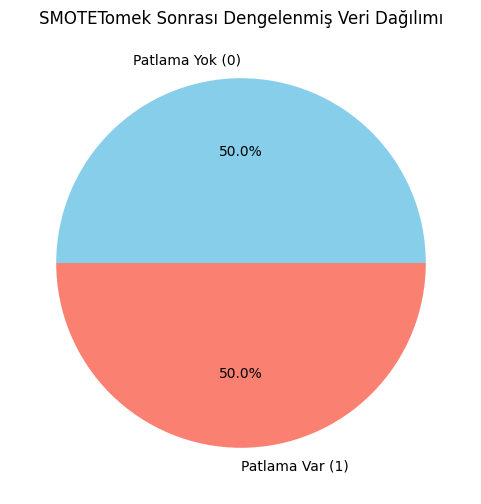

In [2]:
# --- HÜCRE 2: Gelişmiş Ön İşleme (Encoding + Scaling + SMOTETomek) ---

print("2. Ön İşleme Başlıyor...")

# A) ENCODING: Kategorik verileri (Harfler) sayısal sütunlara çevirme
# drop_first=True diyerek gereksiz sütun tekrarını önlüyoruz (Dummy Variable Trap).
data_encoded = pd.get_dummies(data, columns=['Zurich_Class', 'Spot_Size', 'Spot_Distribution'], drop_first=True)

# Girdi (X) ve Çıktı (y) ayrımı
X = data_encoded.drop('target', axis=1)
y = data_encoded['target']

# B) SPLIT: Veriyi bölme (%70 Eğitim, %30 Test)
# stratify=y sayesinde o %18'lik patlama oranını test setinde de koruyoruz.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# C) SCALING: Veriyi standartlaştırma (Ortalama=0, Varyans=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# D) DENGELEME: SMOTETomek (Hem artırma hem temizleme)
print("   -> Sınıf dengesizliği SMOTETomek ile gideriliyor (Biraz zaman alabilir)...")
smt = SMOTETomek(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train_scaled, y_train)

# --- ÇIKTILAR (RAPOR İÇİN) ---
print("\n--- İşlem Sonrası Durum ---")
print(f"Orijinal Eğitim Seti Boyutu: {X_train.shape[0]} satır")
print(f"Dengelenmiş Eğitim Seti Boyutu: {X_train_res.shape[0]} satır")

# Dengeleme Sonrası Grafik
plt.figure(figsize=(6, 6))
y_train_res.value_counts().plot.pie(autopct='%1.1f%%', labels=['Patlama Yok (0)', 'Patlama Var (1)'], colors=['skyblue', 'salmon'])
plt.title("SMOTETomek Sonrası Dengelenmiş Veri Dağılımı")
plt.ylabel('')
plt.show()

3. Modeller Eğitiliyor... (Lütfen bekleyiniz, derin öğrenme zaman alabilir)


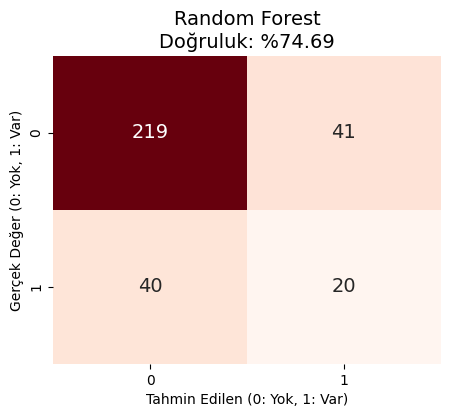

--- Random Forest Detaylı Rapor ---
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       260
           1       0.33      0.33      0.33        60

    accuracy                           0.75       320
   macro avg       0.59      0.59      0.59       320
weighted avg       0.75      0.75      0.75       320



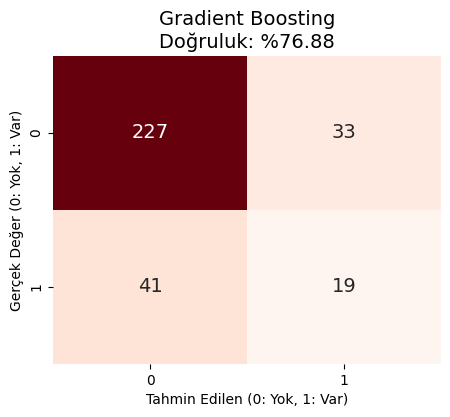

--- Gradient Boosting Detaylı Rapor ---
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       260
           1       0.37      0.32      0.34        60

    accuracy                           0.77       320
   macro avg       0.61      0.59      0.60       320
weighted avg       0.76      0.77      0.76       320



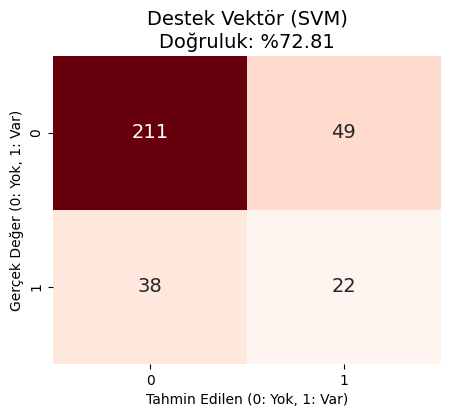

--- Destek Vektör (SVM) Detaylı Rapor ---
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       260
           1       0.31      0.37      0.34        60

    accuracy                           0.73       320
   macro avg       0.58      0.59      0.58       320
weighted avg       0.75      0.73      0.74       320



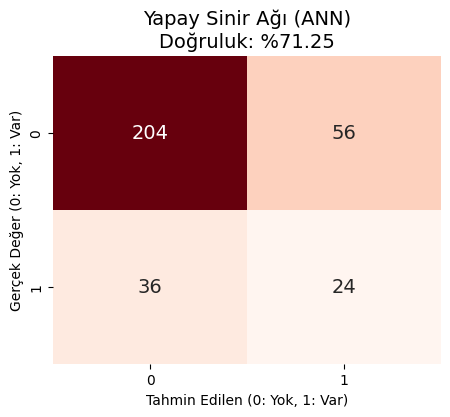

--- Yapay Sinir Ağı (ANN) Detaylı Rapor ---
              precision    recall  f1-score   support

           0       0.85      0.78      0.82       260
           1       0.30      0.40      0.34        60

    accuracy                           0.71       320
   macro avg       0.57      0.59      0.58       320
weighted avg       0.75      0.71      0.73       320


=== GENEL KARŞILAŞTIRMA TABLOSU (PRO V2.0) ===
Algoritma                 | Doğruluk (%)   
----------------------------------------
Gradient Boosting         | 76.88
Random Forest             | 74.69
SVM (Optimize)            | 72.81
Yapay Sinir Ağı (ANN)     | 71.25


In [3]:
# --- HÜCRE 3: Modelleme ve Sonuçların Görselleştirilmesi ---

print("3. Modeller Eğitiliyor... (Lütfen bekleyiniz, derin öğrenme zaman alabilir)")

# Sonuçları Görselleştirme Fonksiyonu
def plot_cm(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred) * 100

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 14})
    plt.title(f"{title}\nDoğruluk: %{acc:.2f}", fontsize=14)
    plt.ylabel('Gerçek Değer (0: Yok, 1: Var)')
    plt.xlabel('Tahmin Edilen (0: Yok, 1: Var)')
    plt.show()

    print(f"--- {title} Detaylı Rapor ---")
    print(classification_report(y_test, y_pred))
    return acc

# 1. Random Forest (Topluluk Öğrenmesi)
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train_res, y_train_res)
acc_rf = plot_cm(rf, X_test_scaled, y_test, "Random Forest")

# 2. Gradient Boosting (XGBoost Mantığı)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train_res, y_train_res)
acc_gb = plot_cm(gb, X_test_scaled, y_test, "Gradient Boosting")

# 3. SVM (Optimize Edilmiş)
svm = SVC(kernel='rbf', C=10, gamma=0.1, random_state=42)
svm.fit(X_train_res, y_train_res)
acc_svm = plot_cm(svm, X_test_scaled, y_test, "Destek Vektör (SVM)")

# 4. Yapay Sinir Ağı (Derin Öğrenme - 3 Katmanlı)
ann = MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=1000, activation='relu', random_state=42)
ann.fit(X_train_res, y_train_res)
acc_ann = plot_cm(ann, X_test_scaled, y_test, "Yapay Sinir Ağı (ANN)")

# --- FİNAL TABLOSU ---
print("\n=== GENEL KARŞILAŞTIRMA TABLOSU (PRO V2.0) ===")
results = {
    "Random Forest": acc_rf,
    "Gradient Boosting": acc_gb,
    "SVM (Optimize)": acc_svm,
    "Yapay Sinir Ağı (ANN)": acc_ann
}

# Sonuçları sırala
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

print(f"{'Algoritma':<25} | {'Doğruluk (%)':<15}")
print("-" * 40)
for alg, score in sorted_results.items():
    print(f"{alg:<25} | {score:.2f}")